<a href="https://colab.research.google.com/github/ThatphumCpre/Bi-GRU_TH_Sentiment_Classification/blob/main/BIGRU_SENTIMENT_THAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration and Implementation ThaiSentiment analysis


This notebook try to implement and exploration about text classification of emotional of text input by using recurrent neutral network

## Summary 
We get quite satisfiable even if we face with weights problem and we still make it happened , Accuracy around 68% with 10-30 epoch and after confusuion matrix we find that we miss classified a lot on pos and q and look ratio of class that those two are imbalanced data 

###Get Data set from wisesight

In [1]:
%%capture
!pip install sklearn_crfsuite
!pip install emoji
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
!pip install fastai
!wget https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
!unzip master.zip
!mkdir wisesight_data; ls
!cd wisesight-sentiment-master/kaggle-competition; ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-03-11 08:59:46--  https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/refs/heads/master [following]
--2023-03-11 08:59:46--  https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/refs/heads/master
Resolving codeload.

### Import visualiztion tools

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from pythainlp.ulmfit import process_thai

#viz
import matplotlib.pyplot as plt
import seaborn as sns

### Text process example
So process_thai is thai tokenizer and data cleansing with newmm 


In [2]:
process_thai("บ้านนนนน ()อยู่นานนานนาน 😂🤣😃😄😅 PyThaiNLP amp;     www.google.com")

['บ้าน',
 'xxrep',
 'อยู่',
 'xxwrep',
 'นาน',
 '😂',
 '🤣',
 '😃',
 '😄',
 '😅',
 'pythainlp',
 '&',
 'xxurl']

### Read all file 
reference : begining of text process is from pythainlp sentiment ulmfit

In [3]:
with open("wisesight-sentiment-master/kaggle-competition/train.txt") as f:
    texts = [line.strip() for line in f.readlines()]

with open("wisesight-sentiment-master/kaggle-competition/train_label.txt") as f:
    categories = [line.strip() for line in f.readlines()]

all_df = pd.DataFrame({"category":categories, "texts":texts})
all_df.to_csv('all_df.csv',index=False)
all_df


,category,texts
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,neu,คะ
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,neu,😅😅😅
4,neu,สวัสดีวันพุธ แนน อะไรนะ
...,...,...
24058,neg,แม่งควายล้วนนน
24059,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25
24060,neg,ค่าชุดอาจจะแพงกว่าส่วนลด
24061,neu,รัฐต้องการแค่ภาษีครับ


In [4]:
with open("wisesight-sentiment-master/kaggle-competition/test.txt") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape

(2674, 2)

In [218]:
#prevalence
ratio = all_df.category.value_counts() / all_df.shape[0]
ratio.to_numpy()

array([0.54461206, 0.25516353, 0.17869759, 0.02152683])

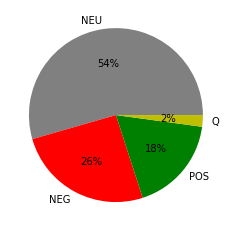

In [224]:
  
# plotting data on chart
plt.pie(ratio.to_numpy(), labels=["NEU", "NEG", "POS", "Q"], colors=["Gray","RED","g", "y"], autopct='%.0f%%')
  
# displaying chart
plt.show()

### Cleansing and Tokenize Sentence


In [5]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_thai(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [6]:
#when finding hyperparameters
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

#when actually doing it
# train_df = all_df.copy()
# valid_df = pd.read_csv('valid_df.csv')

In [7]:
valid_df.head()

,category,texts,processed,wc,uwc
0,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอ|พ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|น...,47,42
1,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้|คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|...,42,40
2,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,46,35
3,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,70,55
4,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,381,218


In [8]:
splited_text  = all_df["processed"].to_numpy()
text_word = []
for sentence in splited_text : 
  for word in sentence.split("|") :
      text_word.append(word)
print(len(text_word))

525965


## Install and get pretrain from Large-Thai2vec
reference : https://github.com/PyThaiNLP/large-thaiword2vec


In [9]:
!pip install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from gensim.models import KeyedVectors

In [11]:
!wget https://zenodo.org/record/7280277/files/LTW2V_v1.0-window15.bin
!wget https://zenodo.org/record/7280277/files/LTW2V_v1.0-window5.bin

--2023-03-11 09:35:03--  https://zenodo.org/record/7280277/files/LTW2V_v1.0-window15.bin
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960468057 (916M) [application/octet-stream]
Saving to: ‘LTW2V_v1.0-window15.bin’

LTW2V_v1.0-window15  29%[====>               ] 270.37M   326KB/s    eta 34m 0s ^C
--2023-03-11 09:49:20--  https://zenodo.org/record/7280277/files/LTW2V_v1.0-window5.bin
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960468057 (916M) [application/octet-stream]
Saving to: ‘LTW2V_v1.0-window5.bin.1’

LTW2V_v1.0-window5.   0%[                    ] 838.99K   310KB/s               ^C


### Load pretrain model


In [12]:
model5 = KeyedVectors.load_word2vec_format('LTW2V_v1.0-window5.bin', binary=True, unicode_errors='ignore')
#model15 = KeyedVectors.load_word2vec_format('LTW2V_v1.0-window15.bin', binary=True, unicode_errors='ignore')

In [13]:
!pip install torch
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Convert to pytorch weight 
to put in our achitecture so we use this weight to put in pytorch embedding layer


In [14]:
weights = torch.FloatTensor(model5.vectors)

### Try Example of word


In [208]:
word = "ยินดี"
idx = model5.vocab[word].index
word_vec  = model5.get_vector(word)


In [203]:
import torch.nn as nn
embedding = nn.Embedding.from_pretrained(weights)
embedding

Embedding(595659, 400)

### Cross validation from pretrain model to weight


In [210]:
torch.all(embedding(torch.tensor(idx)) == torch.tensor(word_vec))

tensor(True)

### Check is any problem with weight
**sometimes author got weight with nan and cause problem, maybe connection between sever and client 

In [211]:
torch.any(torch.isnan(weights))

tensor(False)

In [17]:
tensor_in = torch.LongTensor([idx])

### Padding Sequence of word 


In [18]:
# Define the sequences
import torch.nn.utils.rnn as rnn_utils
seq1 = [1, 2, 3]
seq2 = [4, 5]
seq3 = [6, 7, 8, 9, 10, 11]

# Pad the sequences and create a mask tensor
padded_seqs = rnn_utils.pad_sequence([torch.LongTensor(seq1), torch.LongTensor(seq2), torch.LongTensor(seq3)], batch_first=True)

In [19]:
sentences = ["ค่า|ชุด|อาจจะ|แพง|กว่า|ส่วนลด".split("|")]
sentences

[['ค่า', 'ชุด', 'อาจจะ', 'แพง', 'กว่า', 'ส่วนลด']]

### Label Encoding from str->int to  valdation in our model 
 

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
all_df['label'] = le.fit(all_df['category']).transform(all_df['category'])
valid_df['label'] = le.transform(valid_df['category'])
train_df['label'] = le.transform(train_df['category'])

### Create Custom dataloader for batch and down padding length
padding every downstream of batching to decrease seq_len

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

max_seq_len = 500

class SentimentDataset(Dataset):
    def __init__(self, data, word2veckeyd):
        self.data = data
        self.vocab = word2veckeyd
        x  = data["processed"].apply(lambda x : x.split("|")).to_numpy()
        self.indexed_sentences = [torch.tensor([model5.vocab[token].index if  token in model5 else model5.vocab[""].index  for token in sentence ]) for sentence in x]
       
        y = data["category"].to_numpy
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Tokenize the text and convert to indices using the vocab
        x = self.indexed_sentences[idx] 
        y = self.data["label"].to_numpy()[idx]

        labels = torch.zeros(4)
        labels[y] = 1
        
        return x, torch.tensor([y])


# Example usage
train_data = sentence


def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)
  return xx_pad, yy_pad.squeeze(1)

train_dataset = SentimentDataset(all_df, model5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

 


for batch in train_loader:
    x, y = batch
    print(x.shape)
    #print(len(train_loader))
    print(y)

torch.Size([32, 169])
tensor([0, 2, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2,
        1, 2, 1, 1, 0, 0, 2, 0])
torch.Size([32, 63])
tensor([3, 1, 2, 0, 0, 0, 0, 3, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 0, 0,
        0, 0, 0, 0, 2, 2, 1, 1])
torch.Size([32, 80])
tensor([2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0,
        1, 1, 1, 1, 0, 0, 2, 1])
torch.Size([32, 128])
tensor([1, 1, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1,
        0, 1, 2, 1, 0, 2, 0, 0])
torch.Size([32, 175])
tensor([1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1])
torch.Size([32, 190])
tensor([2, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 1])
torch.Size([32, 412])
tensor([1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        3, 2, 2, 0, 1, 1, 1, 0])
torch.Size([32, 140])
tensor([1, 0, 0, 0, 2, 0, 2, 0, 1, 

### Create Architecture Bi-GRU 
*** problem that  author have met is the weight from pretrain  have nan values after get pretrain model then need to make some weight to zero and unfreeze weight afterthat we get better result from unfreeze version


In [132]:
class BiGRU(nn.Module):
    def __init__(self, embedding_wv, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.embedding.weight.requires_grad = True
        self.embedding.weight.data[torch.isnan(self.embedding.weight.data)] = 0
        self.embedding.weight.data[torch.isinf(self.embedding.weight.data)] = 0
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=dropout, batch_first = False)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text = [sent len, batch size]
        #print("embeded out", torch.any(torch.isnan(text)))
        # Embedding layer
        embedded = self.embedding(text)
        # embedded = [sent len, batch size, emb dim]
        #print("embeded out", torch.any(torch.isnan(embedded)))
        # GRU layer
        output, hidden = self.gru(embedded)
        #print("hidden out", hidden)
      
        # output = [sent len, batch size, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        
        # Concatenate the final forward and backward hidden layers
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # hidden = [batch size, hid dim * num directions]
        
        # Fully connected layer
        output = self.fc(hidden)
        # output = [batch size, output dim]
        
        return output


In [133]:
INPUT_DIM = len(model5.vocab)
EMBEDDING_DIM = model5.vector_size
HIDDEN_DIM = 256
OUTPUT_DIM = 4
DROPOUT = 0.5


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [135]:
!nvidia-smi

Sat Mar 11 10:36:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |  10783MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Instance model to device

In [136]:
model = BiGRU(weights, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model = model.to(device)

In [137]:
BATCH_SIZE = 64

### Create loss function using CrossEntropy  and optimizer

In [138]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters() , lr=0.001, betas=(0.9, 0.999), eps=1e-8,)
criterion = nn.CrossEntropyLoss()


### Create training function


In [139]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in tqdm(iterator):
      
        optimizer.zero_grad()
        
        texts = batch.permute(1,0)
        
        #print("input shape", texts.shape)
        predictions = model(texts.to(device)).squeeze(1)
        #print("pred, label", predictions.shape, labels.shape)
        loss = criterion(predictions, labels.to(device))
        
        acc = accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
  
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [140]:
def accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    predicted_classes = torch.argmax(rounded_preds.to(device), dim=1)
    accuracy = (predicted_classes == y.to(device)).float().mean()
    return accuracy

In [141]:
train_dataset = SentimentDataset(train_df, model5 )
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

In [151]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    temp
    model.eval()
    batch_input, batch_output = [], []
    with torch.no_grad():
        for batch, labels in iterator:
            text = batch.permute(1,0)
            
            predictions = model(text.to(device)).squeeze(1)
            
            loss = criterion(predictions, labels.to(device))

            rounded_preds = torch.round(torch.sigmoid(preds))
            predicted_classes = torch.argmax(rounded_preds.to(device), dim=1)

            batch_input.append(predicted_classes)
            batch_output.append(labels) 

            acc = accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
           
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [143]:
test_dataset = SentimentDataset(valid_df, model5)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

###Train Model

In [144]:
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

100%|██████████| 320/320 [00:50<00:00,  6.35it/s]


Epoch: 01
	Train Loss: 0.837 | Train Acc: 53.70%
	 Val. Loss: 0.705 |  Val. Acc: 58.11%


100%|██████████| 320/320 [00:50<00:00,  6.37it/s]


Epoch: 02
	Train Loss: 0.648 | Train Acc: 61.07%
	 Val. Loss: 0.692 |  Val. Acc: 60.29%


100%|██████████| 320/320 [00:49<00:00,  6.40it/s]


Epoch: 03
	Train Loss: 0.544 | Train Acc: 63.29%
	 Val. Loss: 0.721 |  Val. Acc: 60.34%


100%|██████████| 320/320 [00:50<00:00,  6.38it/s]


Epoch: 04
	Train Loss: 0.461 | Train Acc: 65.38%
	 Val. Loss: 0.771 |  Val. Acc: 63.12%


100%|██████████| 320/320 [00:49<00:00,  6.40it/s]


Epoch: 05
	Train Loss: 0.374 | Train Acc: 69.22%
	 Val. Loss: 0.838 |  Val. Acc: 66.45%


100%|██████████| 320/320 [00:50<00:00,  6.35it/s]


Epoch: 06
	Train Loss: 0.313 | Train Acc: 72.01%
	 Val. Loss: 0.936 |  Val. Acc: 65.69%


100%|██████████| 320/320 [00:50<00:00,  6.39it/s]


Epoch: 07
	Train Loss: 0.262 | Train Acc: 74.70%
	 Val. Loss: 1.144 |  Val. Acc: 67.91%


100%|██████████| 320/320 [00:50<00:00,  6.38it/s]


Epoch: 08
	Train Loss: 0.233 | Train Acc: 76.25%
	 Val. Loss: 1.100 |  Val. Acc: 64.41%


100%|██████████| 320/320 [00:49<00:00,  6.41it/s]


Epoch: 09
	Train Loss: 0.201 | Train Acc: 77.75%
	 Val. Loss: 1.213 |  Val. Acc: 67.62%


100%|██████████| 320/320 [00:50<00:00,  6.39it/s]


Epoch: 10
	Train Loss: 0.188 | Train Acc: 78.34%
	 Val. Loss: 1.207 |  Val. Acc: 66.23%


### Evaluate by label out to create confusion matrix 

In [156]:
def evaluate_label_out(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
  
    model.eval()
    batch_input, batch_output = [], []
    with torch.no_grad():
        for batch, labels in iterator:
            text = batch.permute(1,0)
            
            predictions = model(text.to(device)).squeeze(1)
            
            loss = criterion(predictions, labels.to(device))

            rounded_preds = torch.round(torch.sigmoid(predictions))
            predicted_classes = torch.argmax(rounded_preds.to(device), dim=1)

            batch_input.append(predicted_classes)
            batch_output.append(labels) 

            acc = accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
           
    return batch_input, batch_output

In [157]:
pred, label = evaluate_label_out(model, test_loader, criterion)

In [192]:
pred_np = ([i.cpu().numpy() for i in pred])
pred_np = np.concatenate(pred_np)

In [193]:
label_np = ([i.cpu().numpy() for i in label])
label_np = np.concatenate(label_np)

In [194]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_np, pred_np)

### Create confusion matrirx 


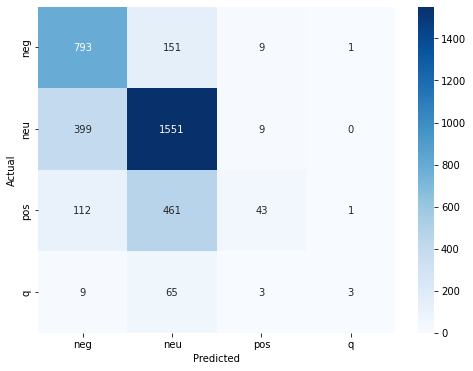

In [198]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=le.inverse_transform([0,1,2,3]), yticklabels=le.inverse_transform([0,1,2,3]))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()